Imports

In [1]:
import os
import pandas as pd
import pickle
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from Data_loader import get_WL_data

In [86]:
WL, labels, station_name_to_id, station_id_to_name = get_WL_data(r'C:\Users\henri\Documents\Universität\Masterthesis\DMI_data\Data_WL')

### Exploring data distribution

In [3]:
zscore=(WL-WL.mean())/WL.std()
threshold=3

Text(0.5, 0, 'Water level [m]')

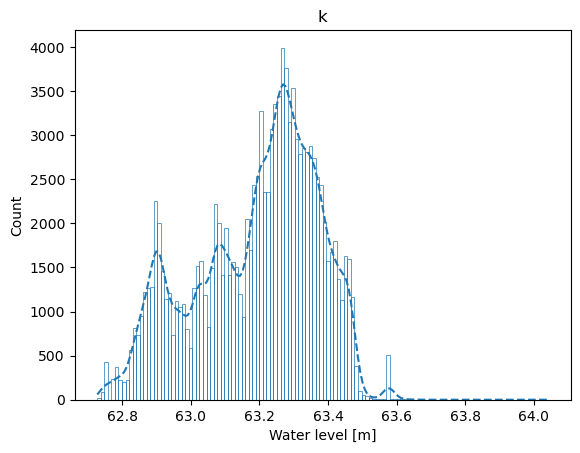

In [4]:
plt.figure()
sns.histplot(data=WL[[WL.columns[0]]], kde=True, legend=False, fill =False, line_kws={"color": "red", "linestyle": "--"})
plt.title('k')
plt.xlabel('Water level [m]')

C:\Users\henri\AppData\Local\Temp\ipykernel_1120\2690061366.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


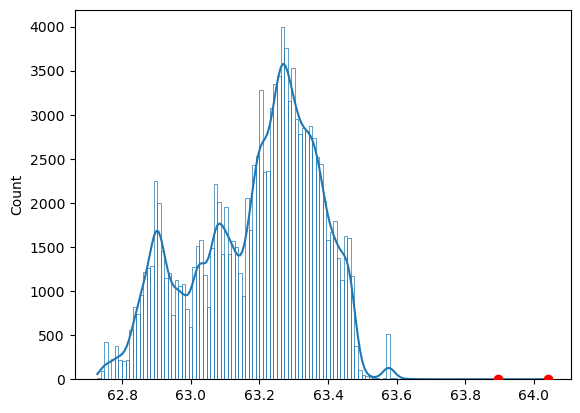

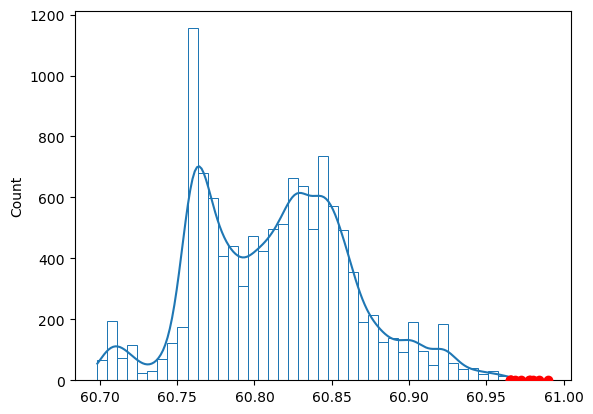

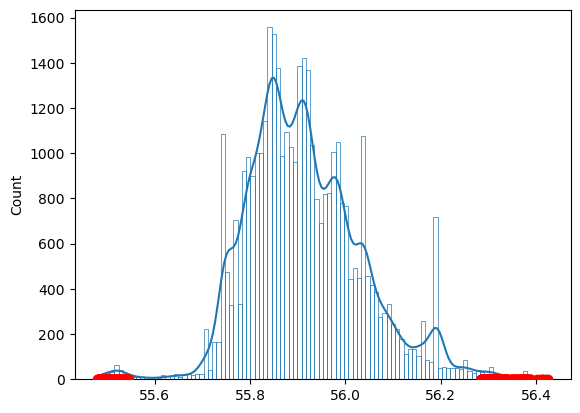

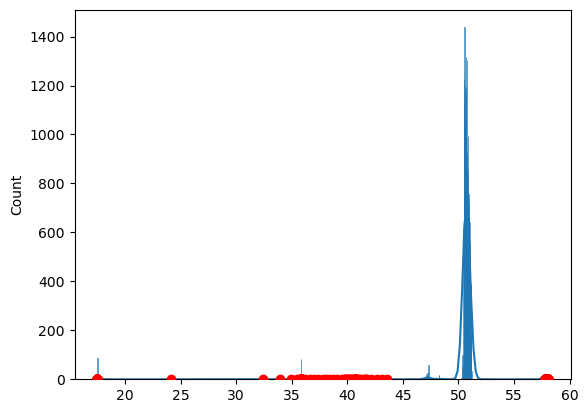

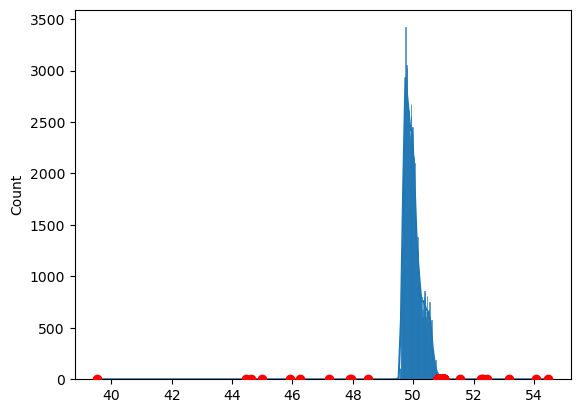

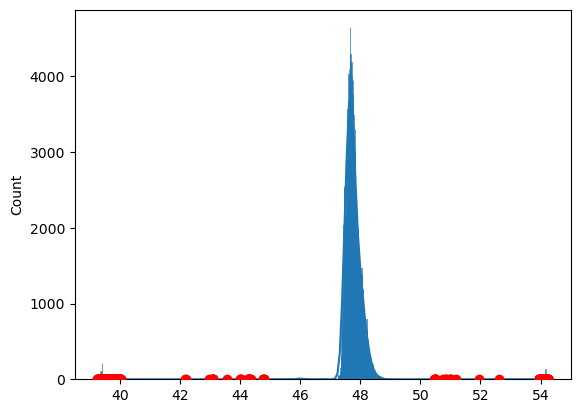

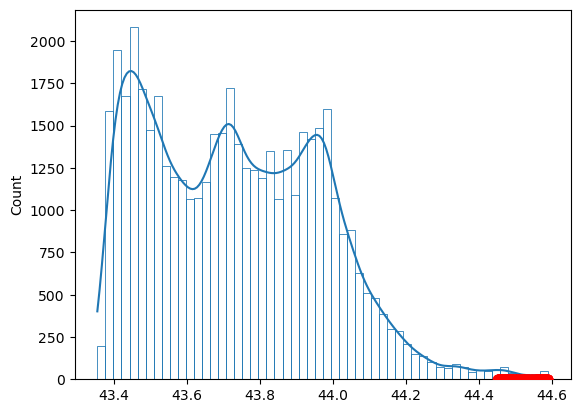

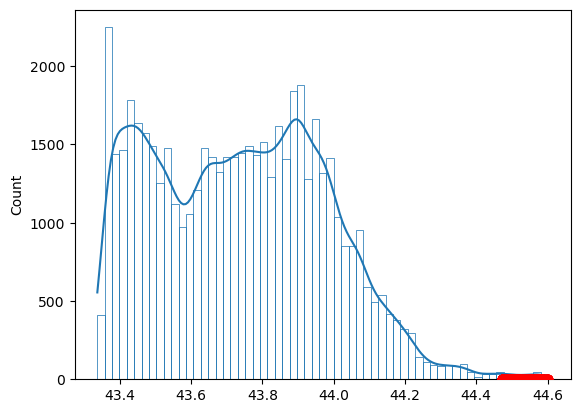

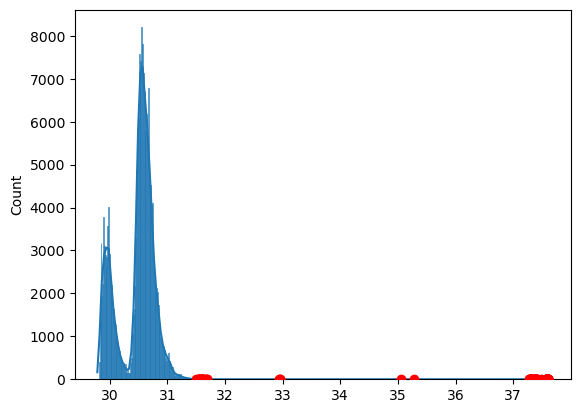

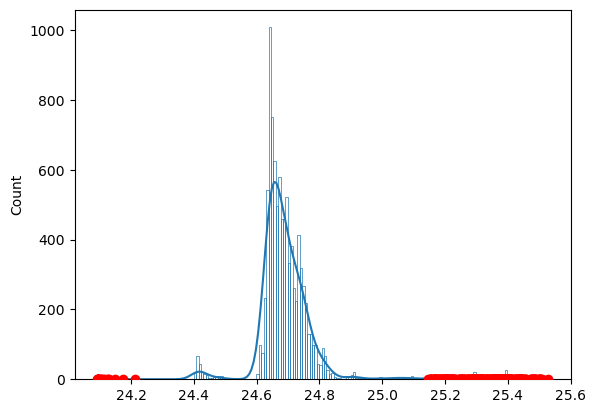

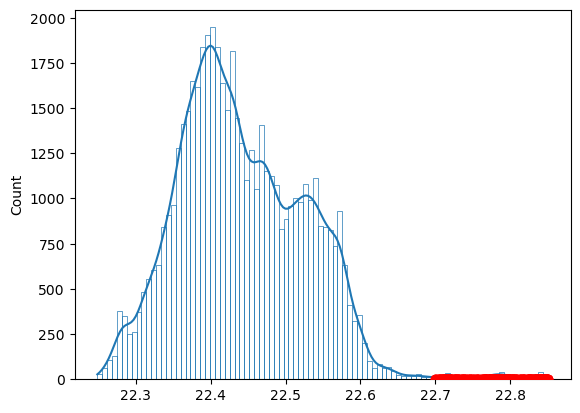

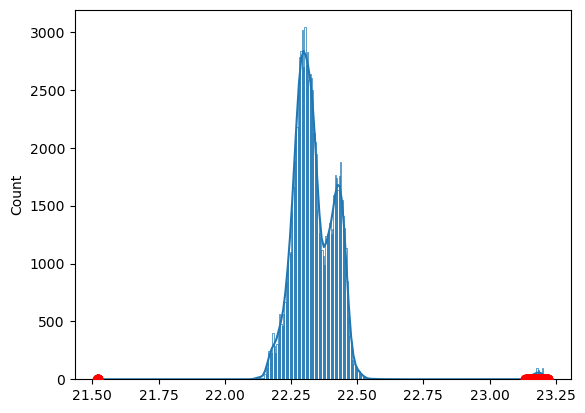

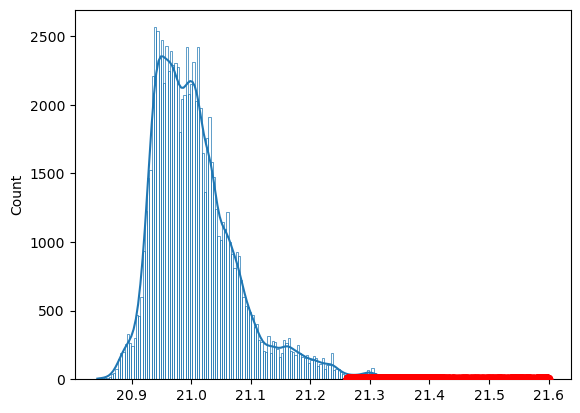

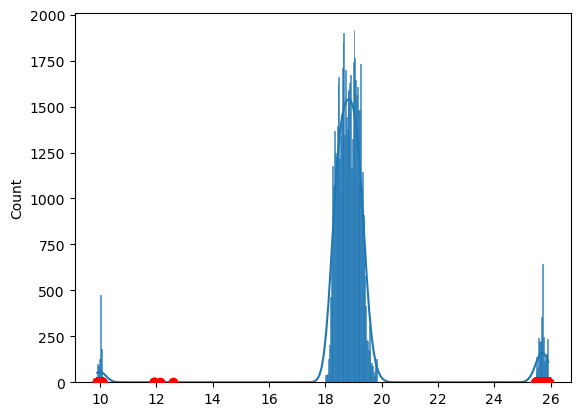

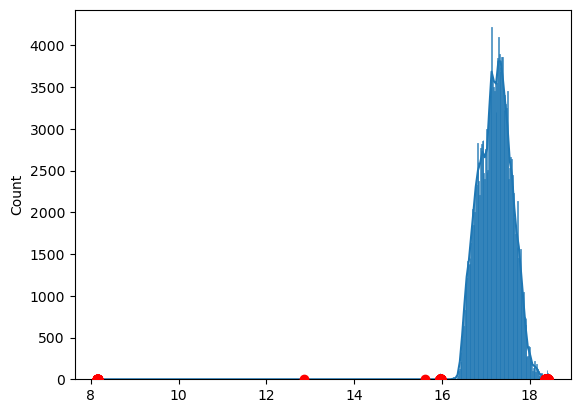

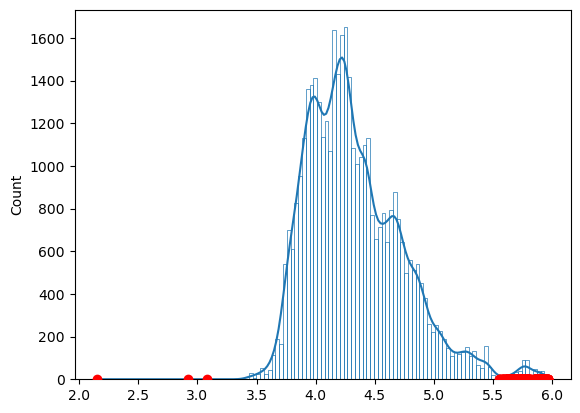

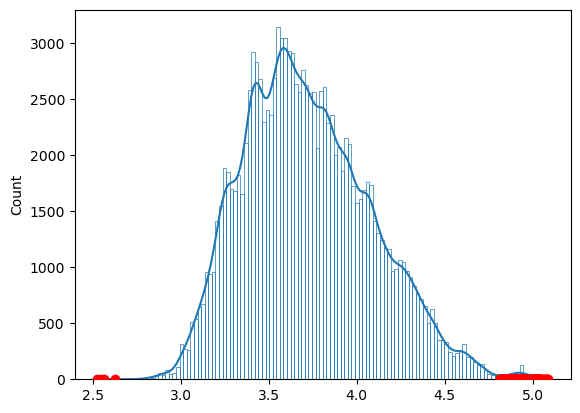

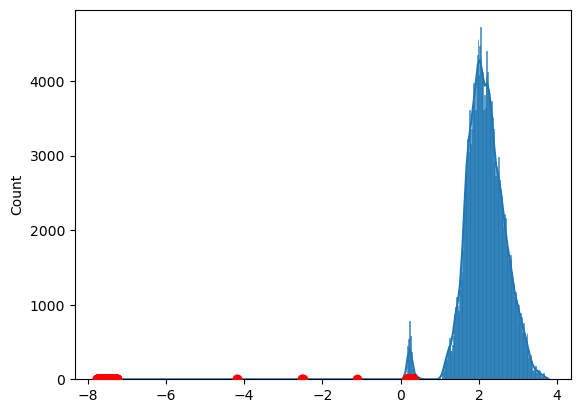

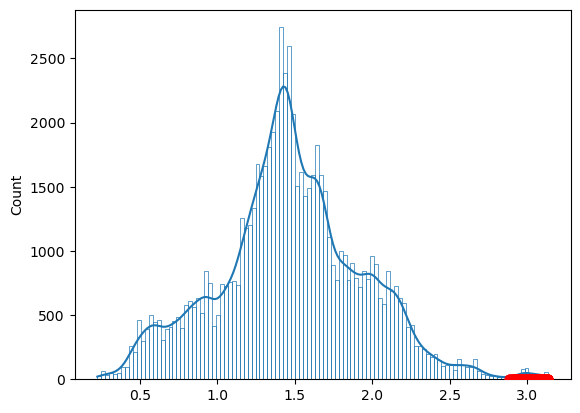

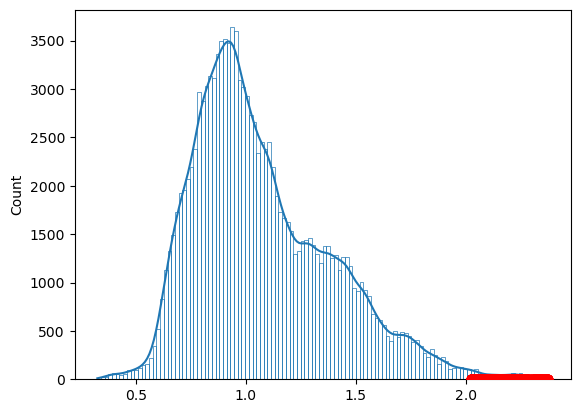

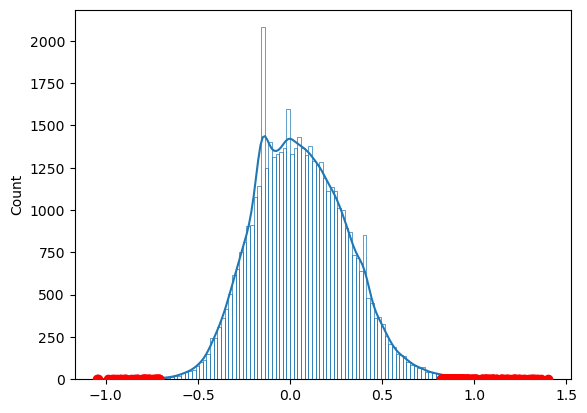

In [111]:
for col in WL.columns:
    outliers=WL[col][np.abs(zscore[col]) > threshold]
    plt.figure()
    ax = sns.histplot(data=WL[[col]],  fill=False, legend=False, kde=True)
    # Highlight outliers in red
    ax.scatter(outliers, np.zeros_like(outliers), color='red', label='Extreme Values', zorder=5)
#sns.kdeplot(data=WL[[WL.columns[0]]],  color='red', ax=ax)


C:\Users\henri\AppData\Local\Temp\ipykernel_1120\2037858669.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


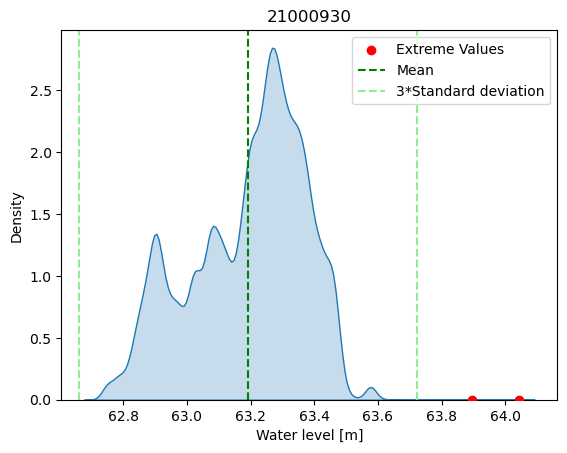

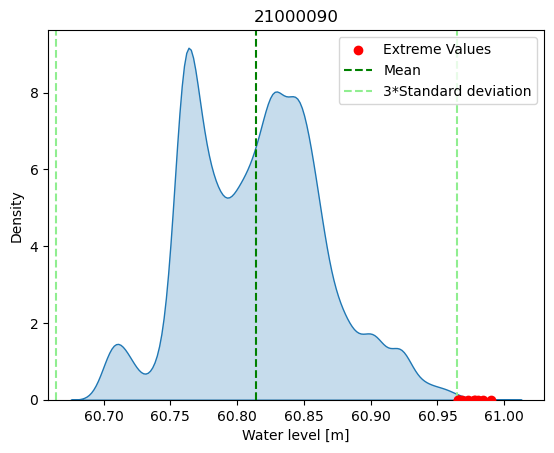

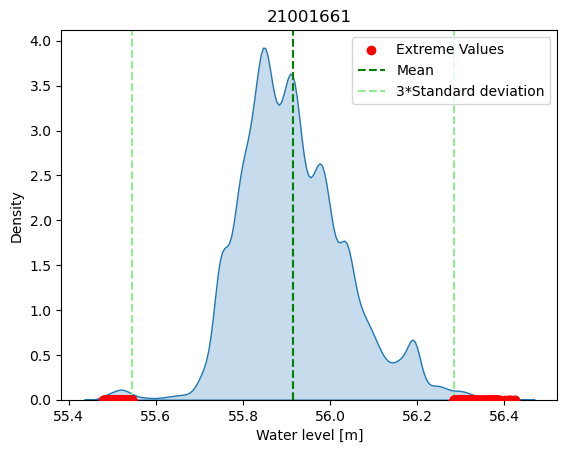

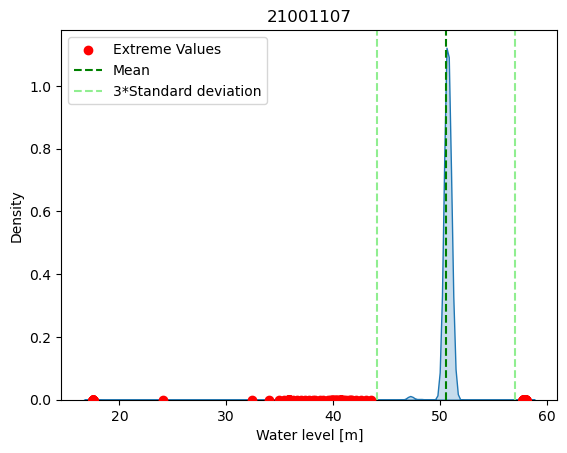

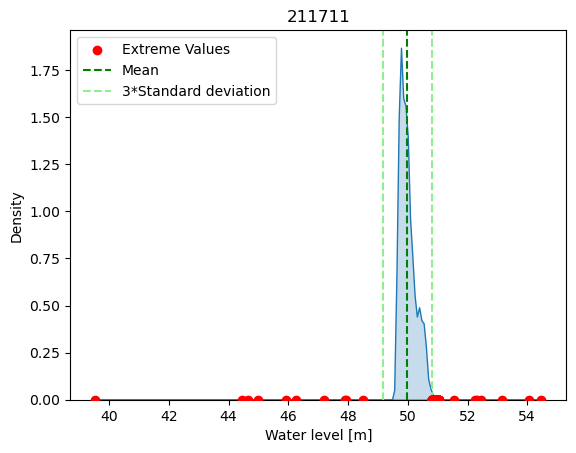

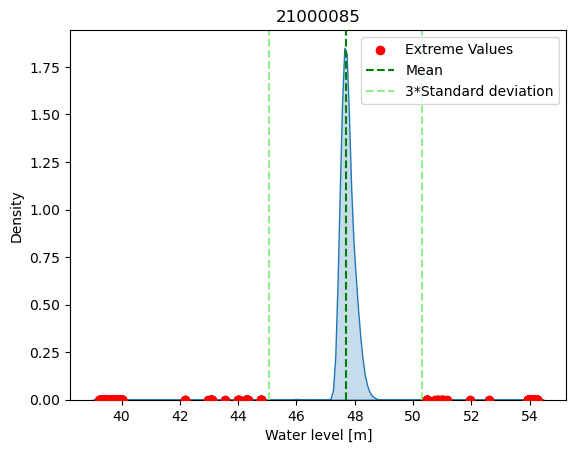

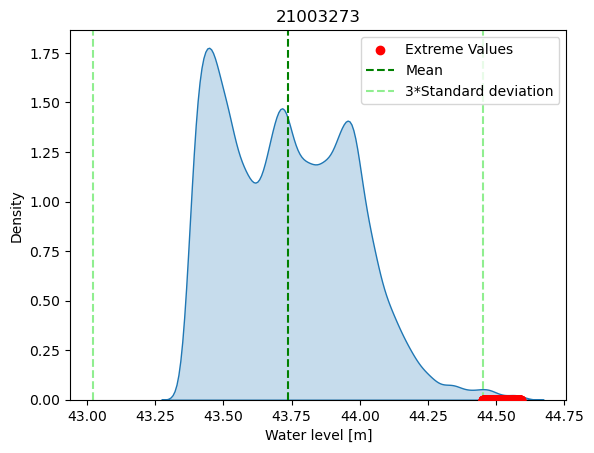

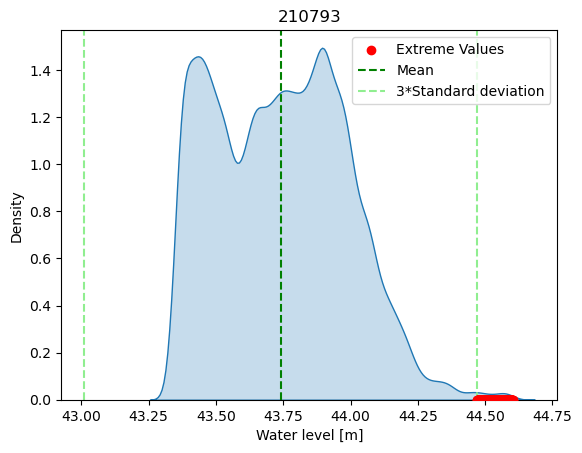

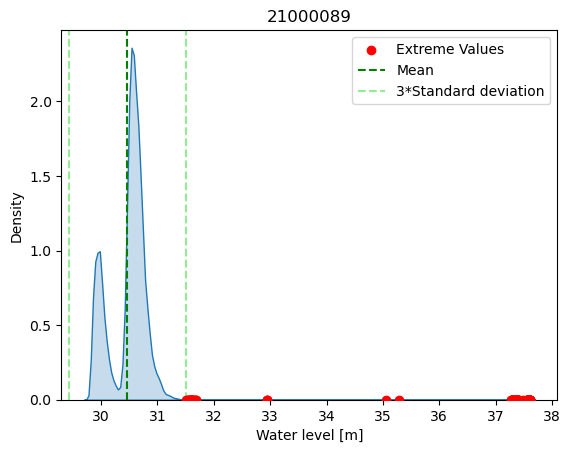

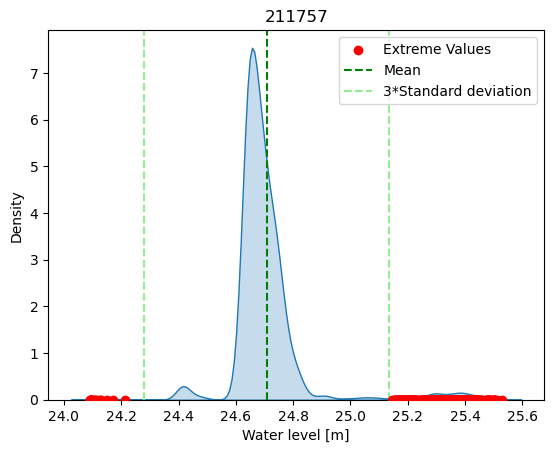

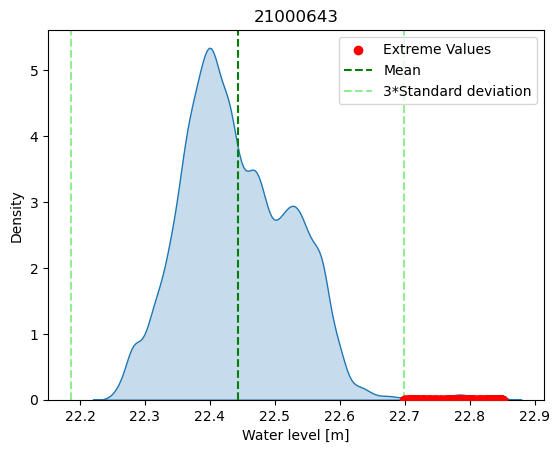

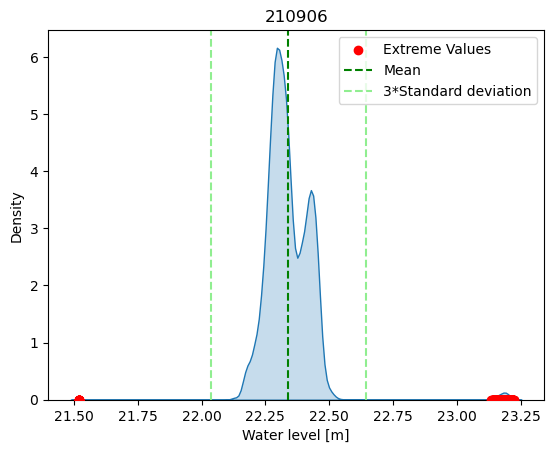

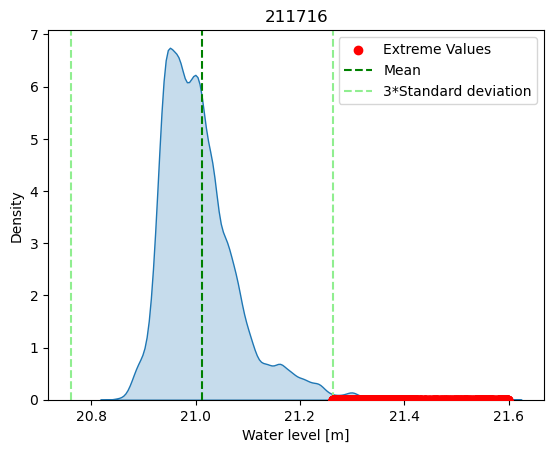

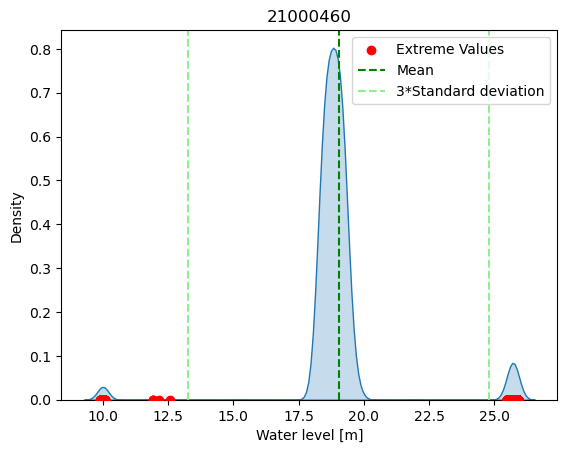

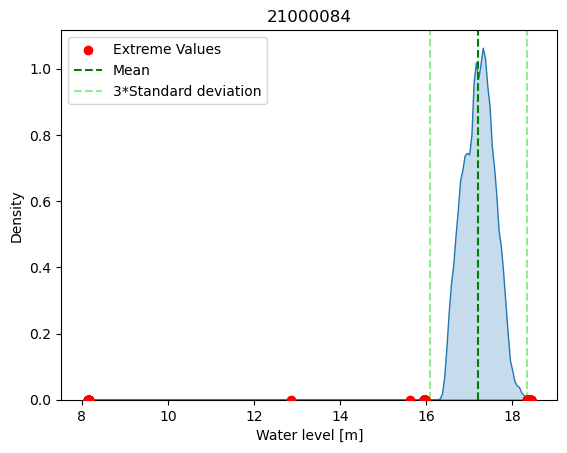

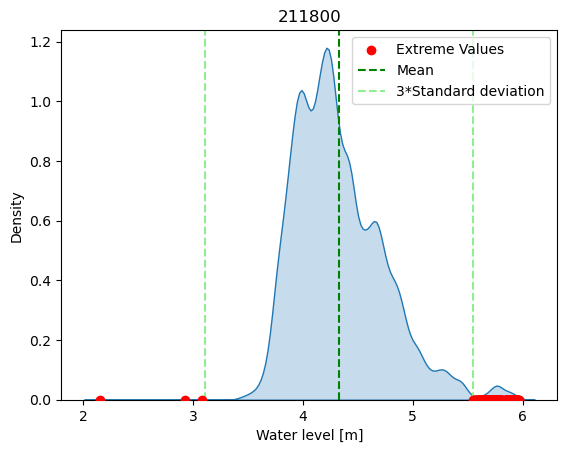

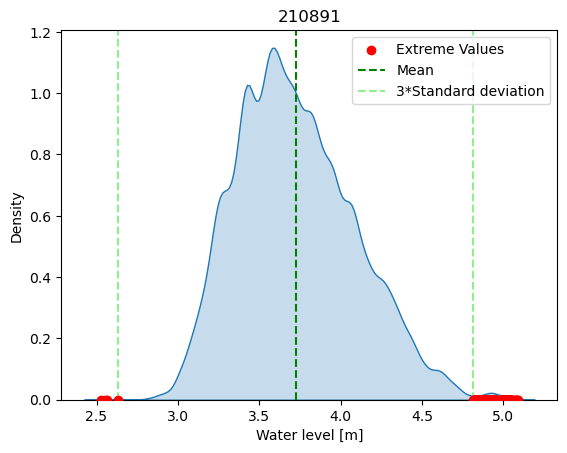

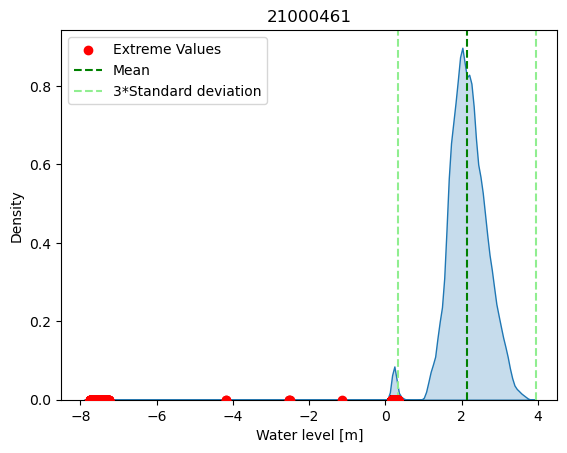

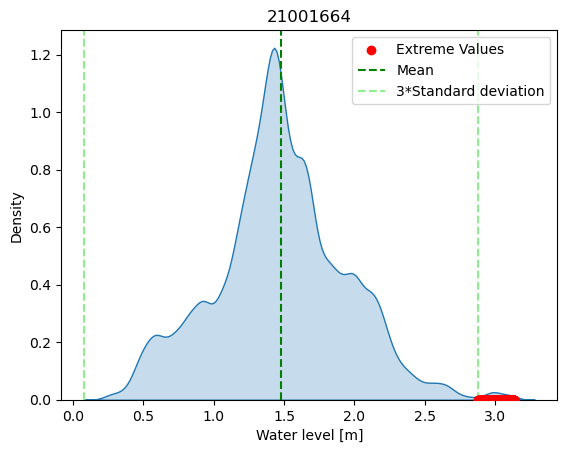

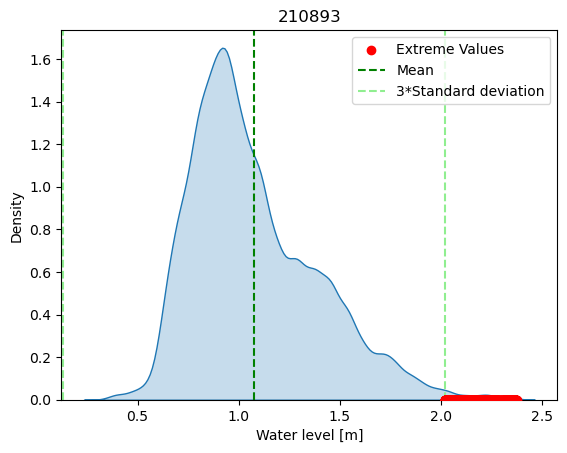

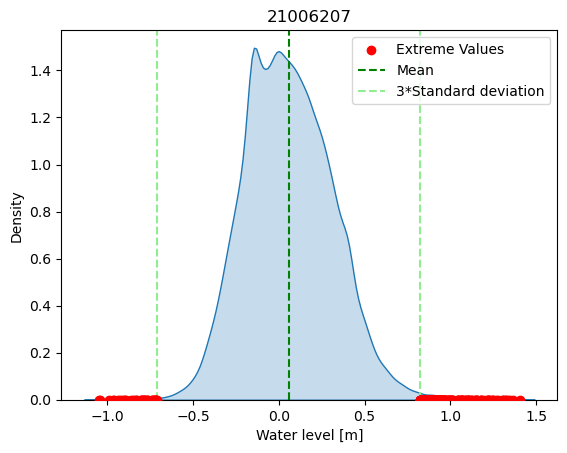

In [147]:
for col in WL.columns:
    outliers=WL[col][np.abs(zscore[col]) > threshold]
    mean=WL[col].mean()
    #median=WL[col].median()
    std=WL[col].std()
    plt.figure()
    ax = sns.kdeplot(data=WL[[col]],  fill=True, legend=False)
    # Highlight outliers in red
    ax.scatter(outliers, np.zeros_like(outliers), color='red', label='Extreme Values', zorder=5)
    #Plot in addition some statistics
    plt.axvline(mean, color='green', linestyle='--', label=f'Mean')
    #plt.axvline(median, color='green', linestyle=':', label=f'Median')    
    plt.axvline((mean+3*std), color='lightgreen', linestyle='--', label=f'3*Standard deviation')
    plt.axvline((mean-3*std), color='lightgreen', linestyle='--')    
    ax.set_xlabel('Water level [m]')
    ax.set_title(col)
    plt.legend()

C:\Users\henri\AppData\Local\Temp\ipykernel_1120\1591237354.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


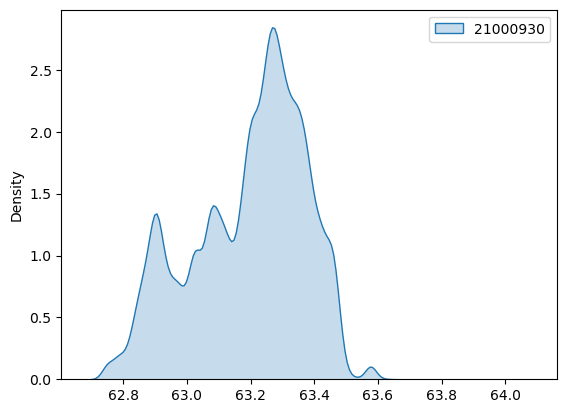

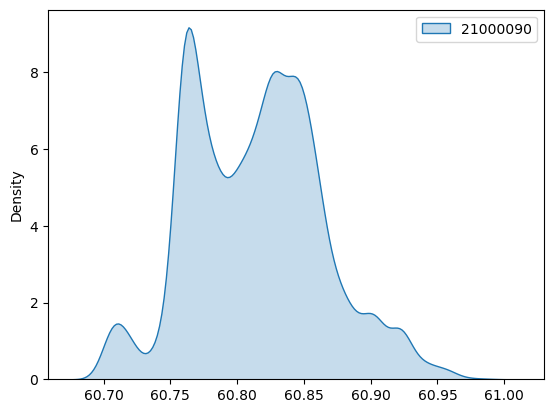

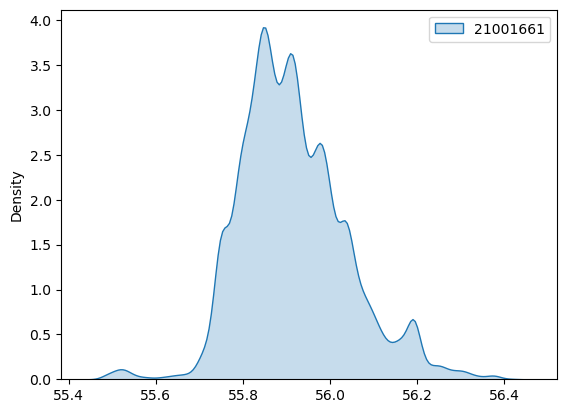

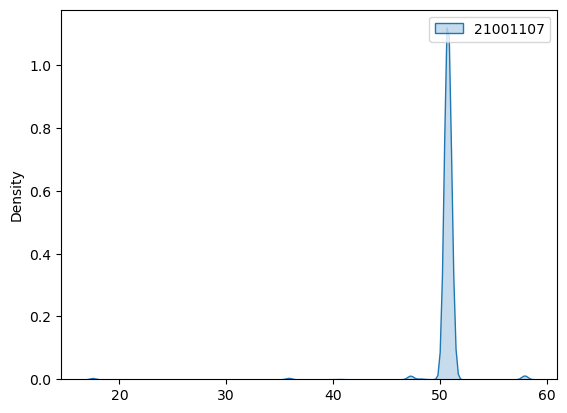

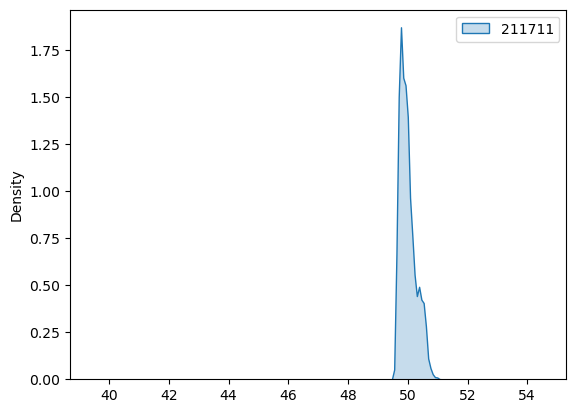

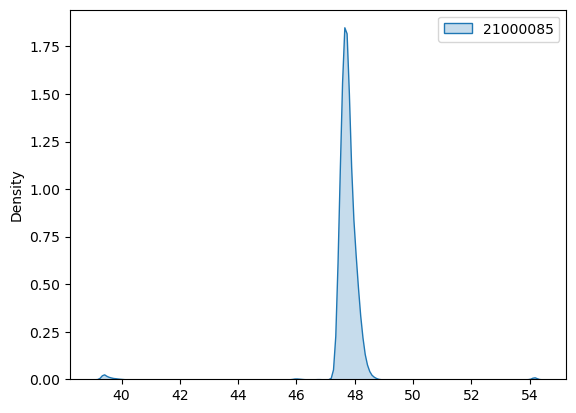

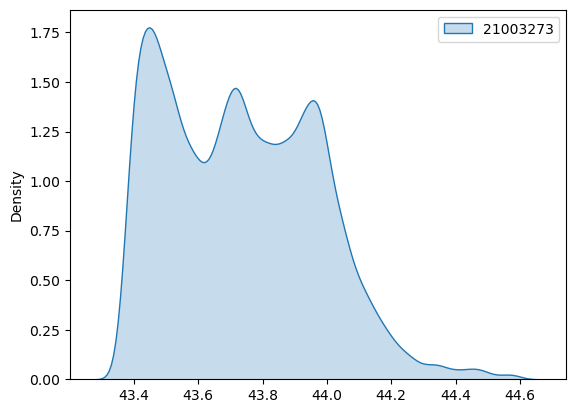

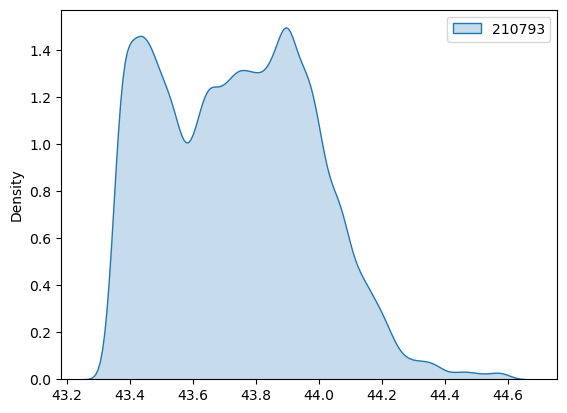

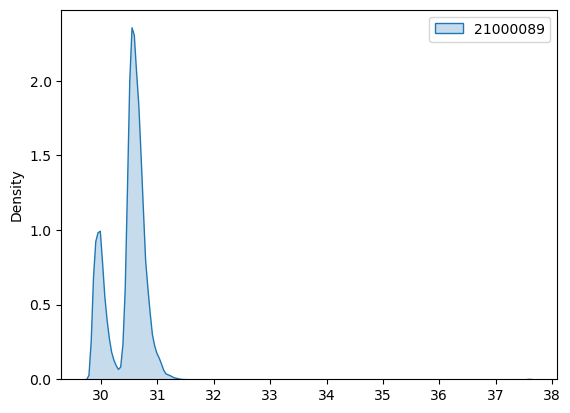

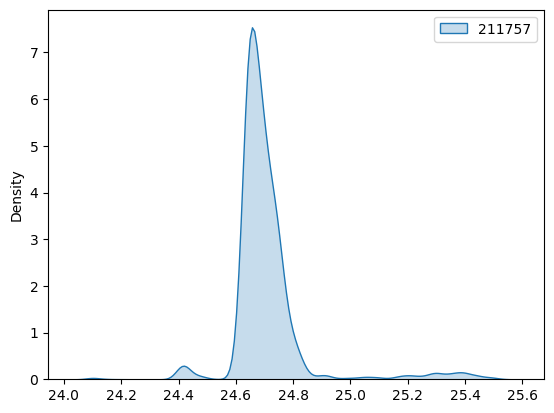

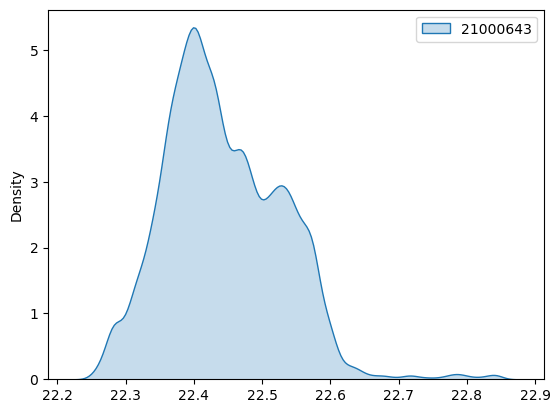

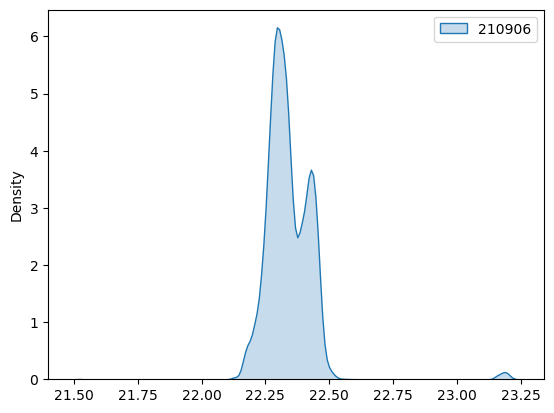

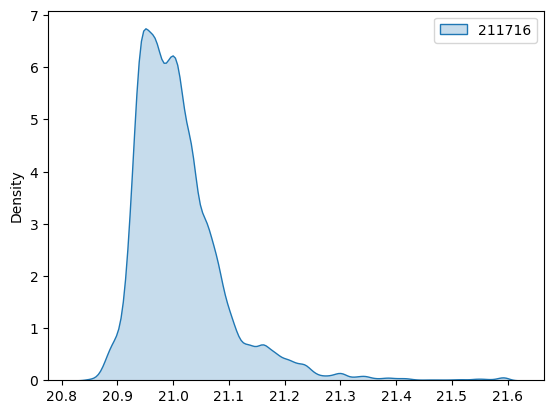

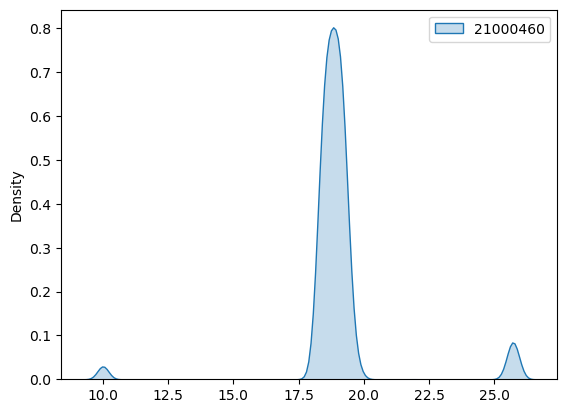

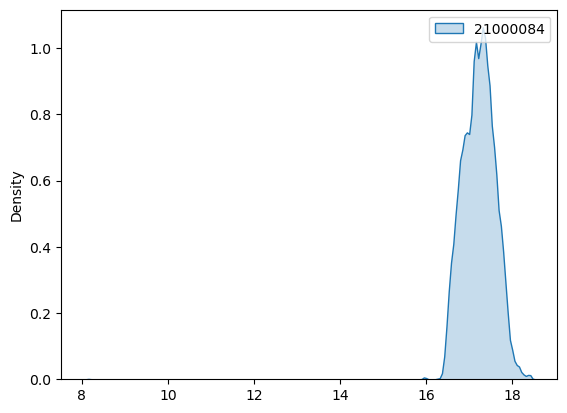

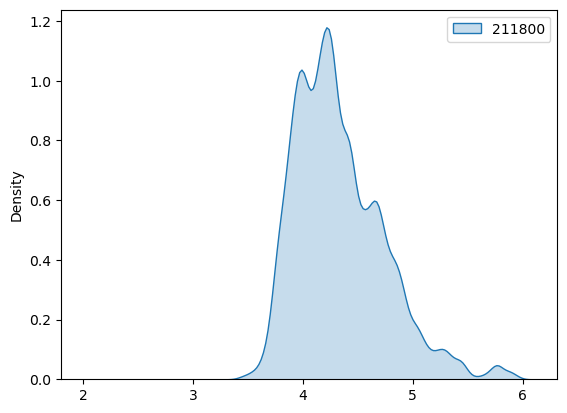

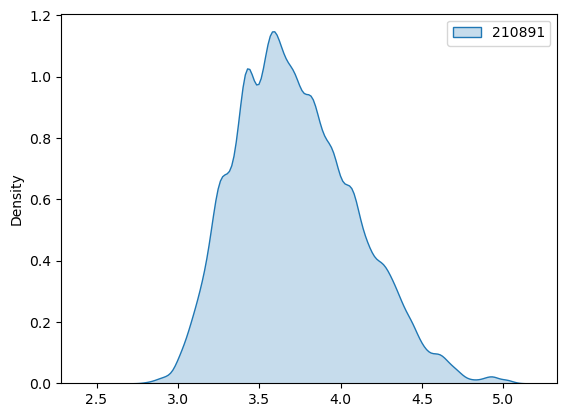

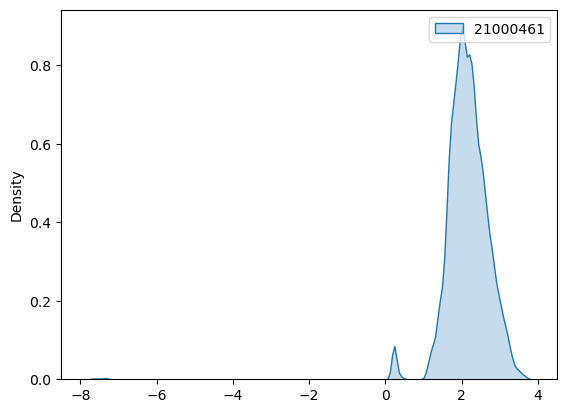

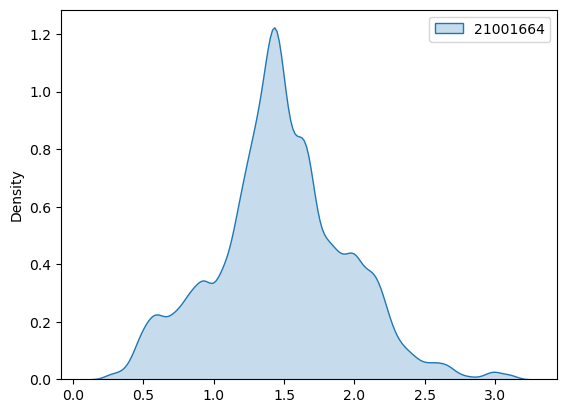

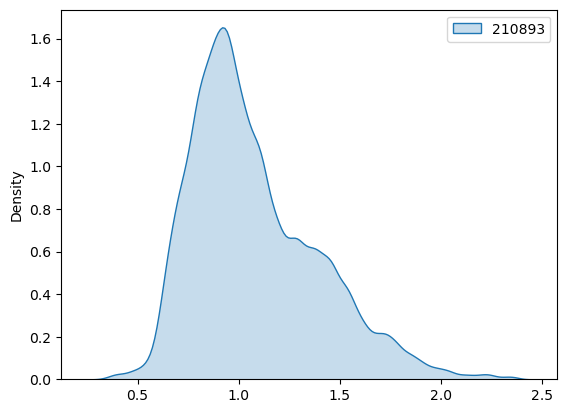

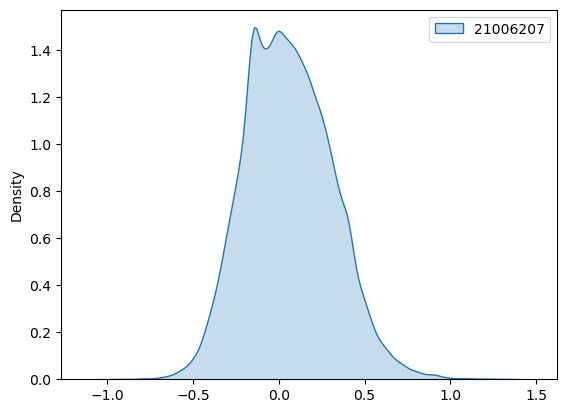

In [73]:
for col in WL.columns:
    plt.figure()
    sns.kdeplot(data=WL[[col]], fill=True)

### Explore missingness of data and occurence of anomalies
<br>
How long are gaps of missing data, how many missing data entries are there?<br>
If we remove anomalies how does it change the amount of missing data and the visualisation of the plots?

<Axes: >

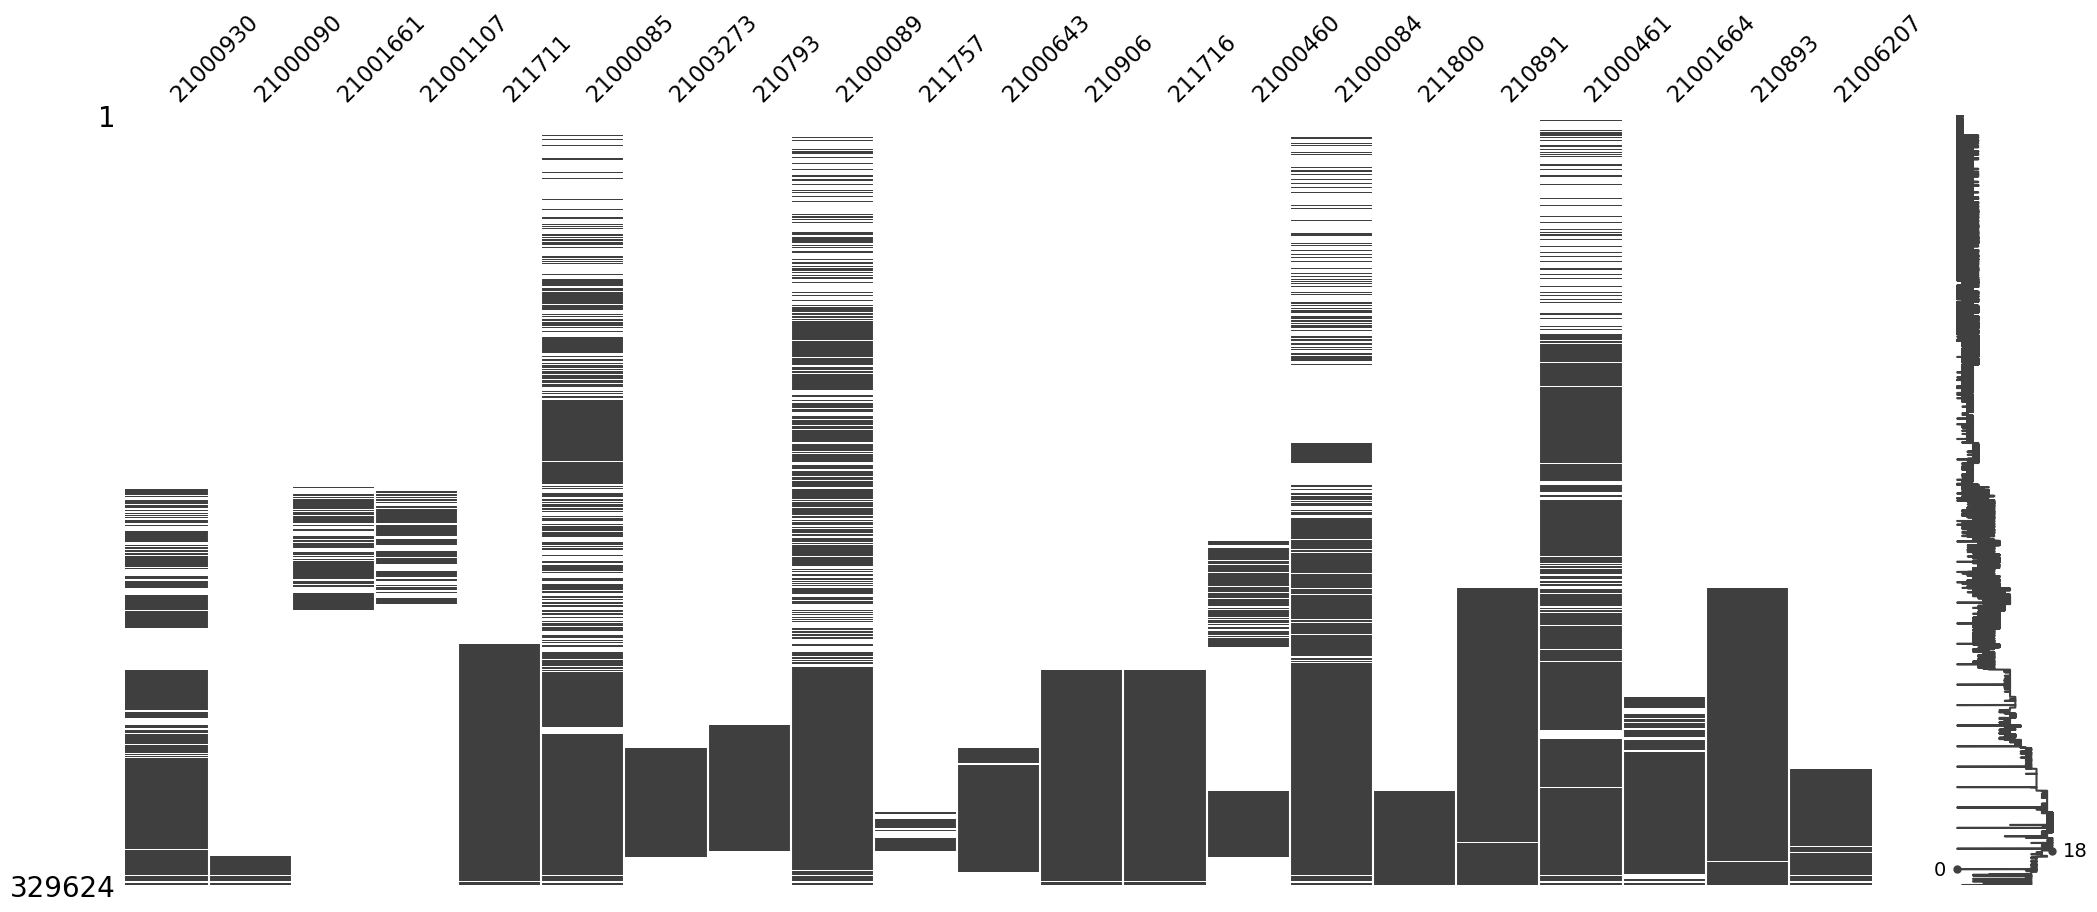

In [3]:
#lets first have again a look on the msno diagram
import missingno as msno
msno.matrix(WL)

Lets examine the length of data gaps and the frequency of these gaps, first for one station 21000461 seems to be a good candidate.


In [106]:
print(station_id_to_name.get('21000084'))

Tvilumbro


In [4]:
testid='21000084'
testdf=WL[[testid]]
testdf=testdf[(testdf.index>testdf.first_valid_index())&(testdf.index<testdf.last_valid_index())] 

Calculate length of the gaps and the frequency of these gap lengths.

In [6]:
import itertools

# Create a list to store gap lengths
gap_lengths = []

# Initialize variables to track the start and end of a gap
gap_start = None

# Iterate through the DataFrame
for idx, row in testdf.iterrows():
    if pd.isna(row[testid]):
        # If water_level is missing, it's the start of a gap
        if gap_start is None:
            gap_start = idx
    else:
        # If water_level is not missing, it's the end of a gap
        if gap_start is not None:
            gap_end = idx
            gap_length = (gap_end - gap_start).total_seconds() / 3600  # Convert to hours, there is no attribute directly outputting the hours
            gap_lengths.append(gap_length)
            gap_start = None  # Reset gap_start

# Convert gap_lengths to a DataFrame and calculate frequency and relative frequency
gap_df = pd.DataFrame(gap_lengths, columns=['Gap Length (hours)'])
gap_freq = gap_df['Gap Length (hours)'].value_counts().reset_index()
gap_freq.columns = ['Gap Length (hours)', 'Frequency']
gap_freq['Relative Frequency']= gap_freq['Frequency']/len(gap_lengths)*100

Let's visualize the results first with boxplots.

<Axes: >

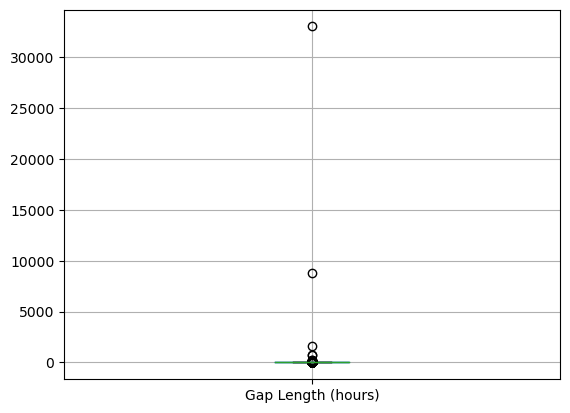

In [7]:
gap_df.boxplot()

And now with normal plots

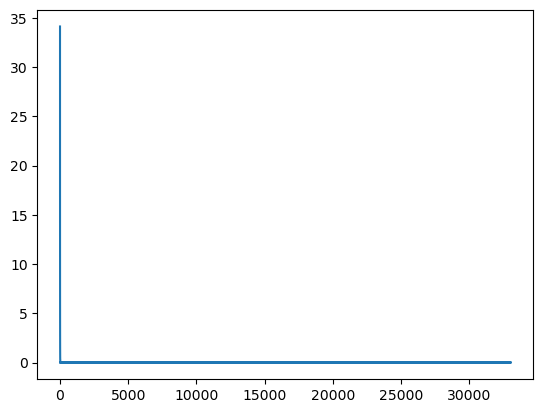

In [8]:
plt.figure()
plt.plot(gap_freq['Gap Length (hours)'], gap_freq['Relative Frequency'])

I think we have to stop using the lines we cant see where the real datapoints are.

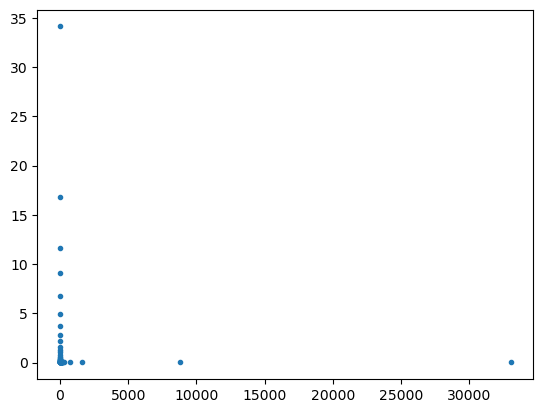

In [9]:
plt.figure()
plt.plot(gap_freq['Gap Length (hours)'], gap_freq['Relative Frequency'], linestyle='', marker='.')

A log transformation of the x-axis might be helpful for seeing the actual values :)

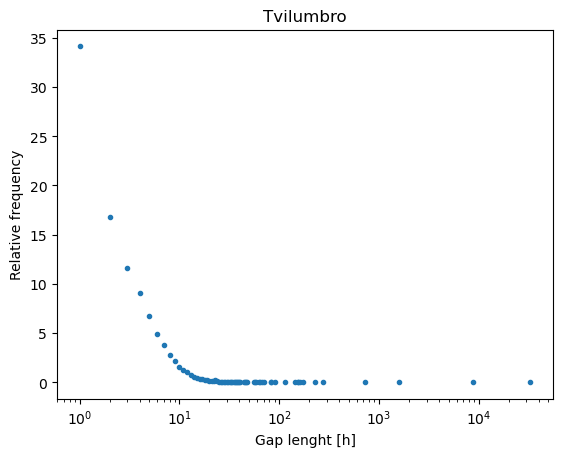

In [53]:
plt.figure()
plt.plot(gap_freq['Gap Length (hours)'], gap_freq['Relative Frequency'], linestyle='', marker='.')
plt.xscale('log')
plt.xlabel('Gap lenght [h]'); plt. ylabel('Relative frequency')
plt.title(f'{station_id_to_name.get(testid)}')
nr_gaps=gap_freq['Frequency'].sum()

In [17]:
def get_gaps(df, id):
    # Create a list to store gap lengths
    gap_lengths = []

    # Initialize variables to track the start and end of a gap
    gap_start = None

    # Iterate through the DataFrame
    for idx, row in df.iterrows():
        if pd.isna(row[id]):
            # If water_level is missing, it's the start of a gap
            if gap_start is None:
                gap_start = idx
        else:
            # If water_level is not missing, it's the end of a gap
            if gap_start is not None:
                gap_end = idx
                gap_length = (gap_end - gap_start).total_seconds() / 3600  # Convert to hours, there is no attribute directly outputting the hours
                gap_lengths.append(gap_length)
                gap_start = None  # Reset gap_start

    # Convert gap_lengths to a DataFrame and calculate frequency and relative frequency
    gap_df = pd.DataFrame(gap_lengths, columns=['Gap Length (hours)'])
    gap_freq = gap_df['Gap Length (hours)'].value_counts().reset_index()
    gap_freq.columns = ['Gap Length (hours)', 'Frequency']
    gap_freq['Relative Frequency']= gap_freq['Frequency']/len(gap_lengths)*100
    return gap_freq

In [21]:
def plot_gaps(df, station_name):    
    plt.figure()
    plt.plot(df['Gap Length (hours)'], df['Relative Frequency'], linestyle='', marker='.')
    plt.xscale('log')
    plt.xlabel('Gap lenght [h]'); plt. ylabel('Relative frequency')
    plt.title(station_name)
    plt.text(2, 15, df['Frequency'].sum())
    plt.show()

In [126]:
gap_df_list=[]
gap_info_df=pd.DataFrame(index=station_id_to_name.values(), columns=['Nr', 'Max', 'Min', 'Most_frequent'])
for station_id, name in station_id_to_name.items():
    df=WL[[station_id]]
    df=df[(df.index>df.first_valid_index())&(df.index<df.last_valid_index())] 
    gap_df=get_gaps(df, station_id)
    #plot_gaps(gap_df, name)
    gap_df_list.append(gap_df)
    #get some statistics
    gap_info_df.loc[[name],['Nr']]=gap_df['Frequency'].sum()
    gap_info_df.loc[[name],['Max']]=gap_df['Gap Length (hours)'].max()
    gap_info_df.loc[[name],['Min']]=gap_df['Gap Length (hours)'].min()
    #Get an idea which gap length is most frequent
    gap_info_df.loc[[name],['Most_frequent']]=(gap_df.loc[gap_df[gap_df['Relative Frequency']==gap_df['Relative Frequency'].max()].index[0],['Gap Length (hours)']])[0]

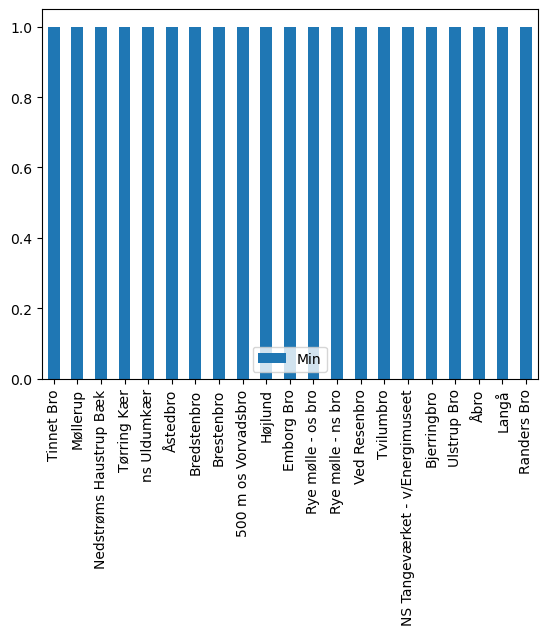

In [133]:
ax=gap_info_df.plot.bar(y=['Max'])

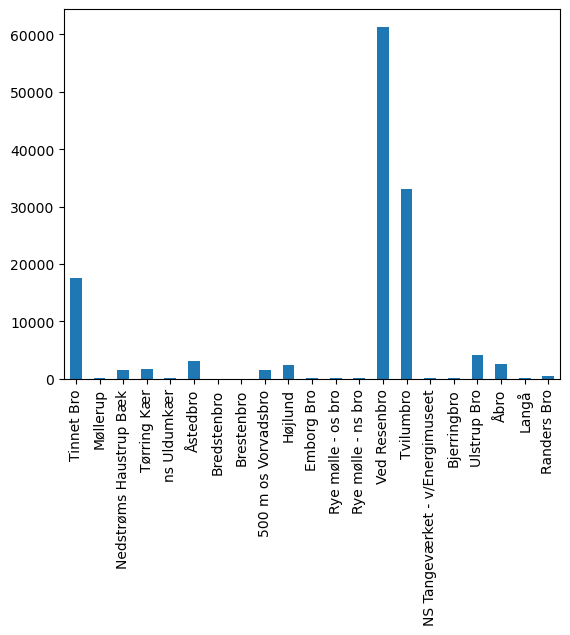

In [134]:
ax=gap_info_df['Max'].plot.bar()

<Axes: title={'center': 'Min'}, ylabel='Gap length [h]'>

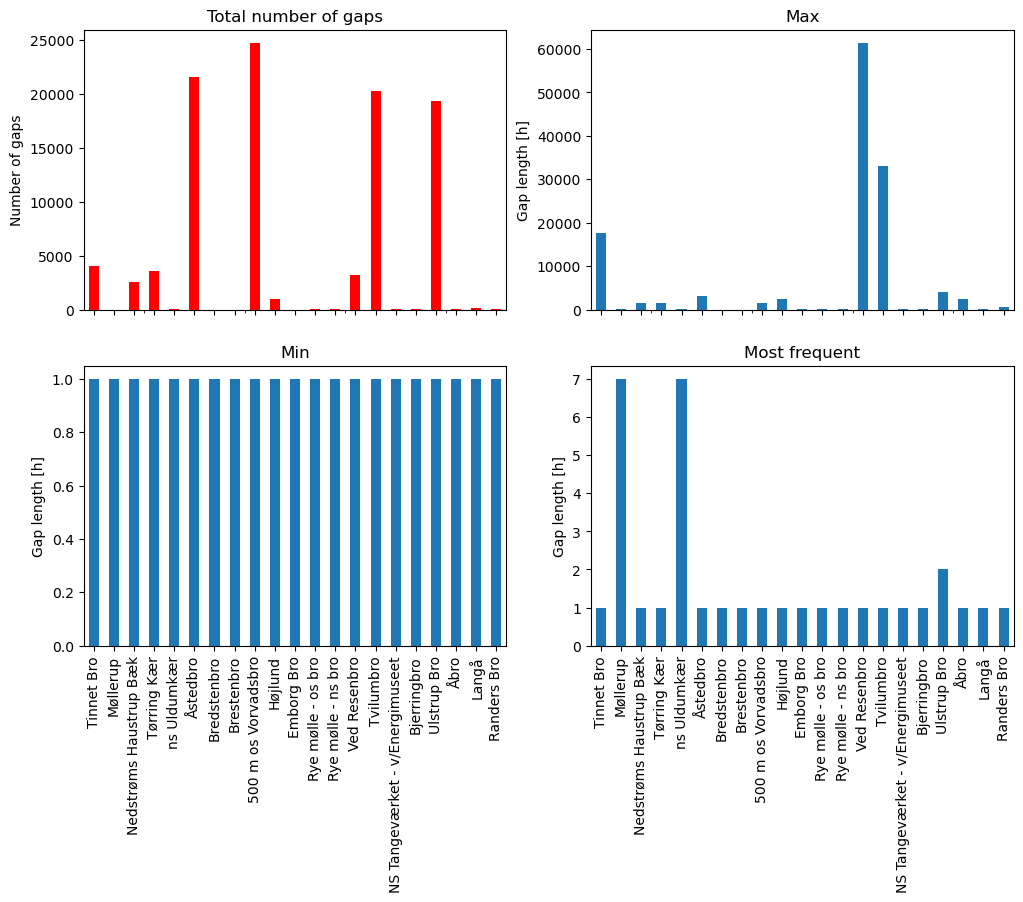

In [163]:
fig, ax = plt.subplots(2,2,figsize=(12,8))
gap_info_df['Nr'].plot.bar(ax=ax[0,0], sharex=True, title='Total number of gaps', ylabel='Number of gaps', color='red')
gap_info_df['Most_frequent'].plot.bar(ax=ax[1,1], sharex=True, title='Most frequent', ylabel='Gap length [h]')
gap_info_df['Max'].plot.bar(ax=ax[0,1],title='Max' ,ylabel='Gap length [h]')
gap_info_df['Min'].plot.bar(ax=ax[1,0], sharex=True, title='Min', ylabel='Gap length [h]')

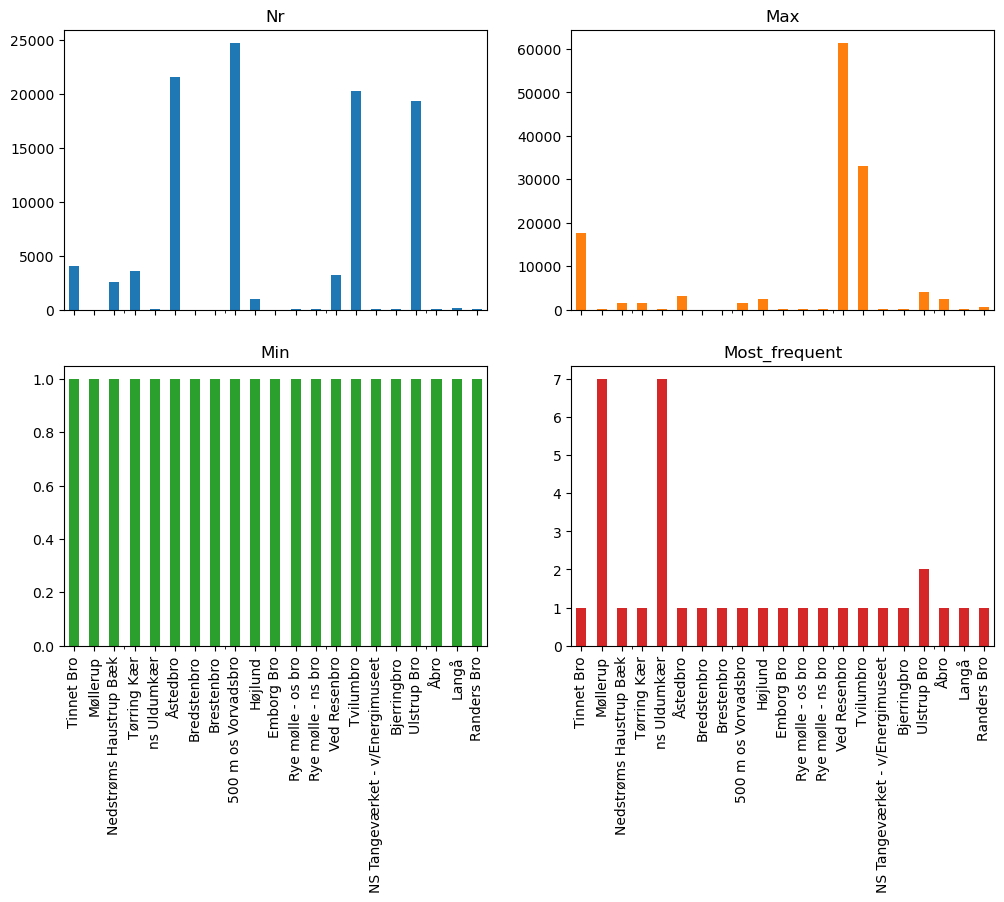

In [147]:
#Alternative way to plot the statistics
axes=gap_info_df.plot.bar(subplots=True, layout=(2,2), figsize=(12,8), legend=False)

## Next steps


Create these plots for all stations. <br>
Maybe better visualisation<br>
Examine this also for anomalies and how anomalies might influence this/might be influened :)